LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [1]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math
import scipy.stats as stats

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [2]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [3]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [4]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

We split the data into three parts, each having different market regime. The return of each regime will be modeled using a Gaussian distribution.

In [5]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
# Get first regime (low volatility)
df_prices_1, _ = dr.get_period(start_date="2016-03-18", end_date="2018-01-31")
# Get second regime (high volatility: crash)
df_prices_2a, _ = dr.get_period(start_date="2018-02-01", end_date="2018-12-31")
df_prices_2b, _ = dr.get_period(start_date="2020-02-01", end_date="2020-03-23")
# Get third regime (high volatility: recovery)
df_prices_3a, _ = dr.get_period(start_date="2019-01-01", end_date="2020-01-31")
df_prices_3b, _ = dr.get_period(start_date="2020-03-24", end_date="2021-03-18")

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [6]:
# log(sum_i(p_i * exp(x_i))) <= t
def logsumexp(M, x, p, t):
    n = int(x.getSize())
    u = M.variable(n)
    M.constraint(Expr.hstack(u, Expr.constTerm(n, 1.0), Expr.sub(x, Var.repeat(t, n))), Domain.inPExpCone())
    M.constraint(Expr.dot(p, u), Domain.lessThan(1.0))

def ExpectedUtility(N, m, G, pi, deltas):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        assert len(m) == len(G), "Wrong number of components!"
        K = len(m)
        
        # Variables 
        # The variable x is the fraction of holdings relative to the initial capital.
        # It is constrained to take only positive values. 
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1.0))
        
        # Auxiliary variables.
        z = M.variable("z", 1, Domain.unbounded())
        q = M.variable("q", K, Domain.unbounded())
        
        # Constraint modeling log-sum-exp
        delta = M.parameter()
        mmat = np.vstack(m)
        expconex = Expr.add(Expr.mul(delta, Expr.mul(-mmat, x)), Expr.mul(delta, Expr.mul(delta, q)))
        logsumexp(M, expconex, pi, z)
        
        # Constraints modeling quadratic terms
        for i in range(K):
            M.constraint(f'quad_{i}', Expr.vstack(q.index(i), 1.0, Expr.mul(G[i].transpose(), x)), Domain.inRotatedQCone())
        
        # Objective
        M.objective('obj', ObjectiveSense.Minimize, z)
        
        # Create DataFrame to store the results.
        columns = ["delta", "inv_delta", "obj"] + list_stocks
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
        
            # Solve optimization
            M.solve()

            # Save results
            row = pd.Series([d, 1/d, M.primalObjValue()] + list(x.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)
            
        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [7]:
# Regime probabilities
pi1 = 0.6
pi2 = 0.1
pi3 = 0.3

# Get optimization parameters
m1, S1 = compute_inputs([df_prices_1])
m2, S2 = compute_inputs([df_prices_2a, df_prices_2b])
m3, S3 = compute_inputs([df_prices_3a, df_prices_3b])

# Number of securities
N = m1.shape[0]

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [8]:
G1 = np.linalg.cholesky(S1)
G2 = np.linalg.cholesky(S2)
G3 = np.linalg.cholesky(S3)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{2}$. We compute the efficient frontier this way both with and without using shrinkage estimation. 

In [9]:
# Compute efficient frontier with and without shrinkage
deltas = np.logspace(start=-0.5, stop=3, num=30)[::-1]
df_result = ExpectedUtility(N, [m1, m2, m3], [G1, G2, G3], [pi1, pi2, pi3], deltas)

Check the results.

In [10]:
df_result

,delta,inv_delta,obj,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,1000.000000,0.001000,18731.291320,1.397580e-01,1.923716e-01,3.170085e-01,1.090248e-01,2.591222e-08,1.069657e-01,1.519071e-08,1.348714e-01
1,757.373918,0.001320,10688.711315,1.377311e-01,2.067615e-01,3.051378e-01,1.131381e-01,5.972648e-09,1.042367e-01,3.513223e-09,1.329949e-01
2,573.615251,0.001743,6096.203322,1.349879e-01,2.258561e-01,2.899170e-01,1.186232e-01,1.001944e-08,1.001285e-01,6.756817e-09,1.304874e-01
3,434.441230,0.002302,3476.947773,1.314341e-01,2.498619e-01,2.716419e-01,1.255402e-01,5.529221e-09,9.423249e-02,4.560346e-09,1.272895e-01
4,329.034456,0.003039,1985.100807,1.268047e-01,2.794974e-01,2.504369e-01,1.341748e-01,5.390696e-09,8.573836e-02,6.777165e-09,1.233478e-01
5,249.202115,0.004013,1136.489090,1.207094e-01,3.151708e-01,2.269486e-01,1.448788e-01,3.525828e-09,7.351449e-02,1.924484e-08,1.187778e-01
6,188.739182,0.005298,653.906127,1.144734e-01,3.449507e-01,2.063878e-01,1.492508e-01,5.820227e-09,5.763630e-02,1.374572e-02,1.135552e-01
7,142.946134,0.006996,378.353194,1.079037e-01,3.656898e-01,1.899979e-01,1.440070e-01,2.314089e-08,3.808689e-02,4.688608e-02,1.074286e-01
8,108.263673,0.009237,220.722846,9.837611e-02,3.852156e-01,1.765971e-01,1.352258e-01,5.129220e-08,1.327560e-02,8.996242e-02,1.013473e-01
9,81.996082,0.012196,130.303499,7.937379e-02,4.047195e-01,1.611928e-01,1.216716e-01,1.146191e-08,6.206749e-08,1.489029e-01,8.413941e-02


## Visualize the results

Plot the portfolio composition.

In [11]:
# Round small values to 0 to make plotting work
mask = np.absolute(df_result) < 1e-7
mask.iloc[:, :-8] = False
df_result[mask] = 0

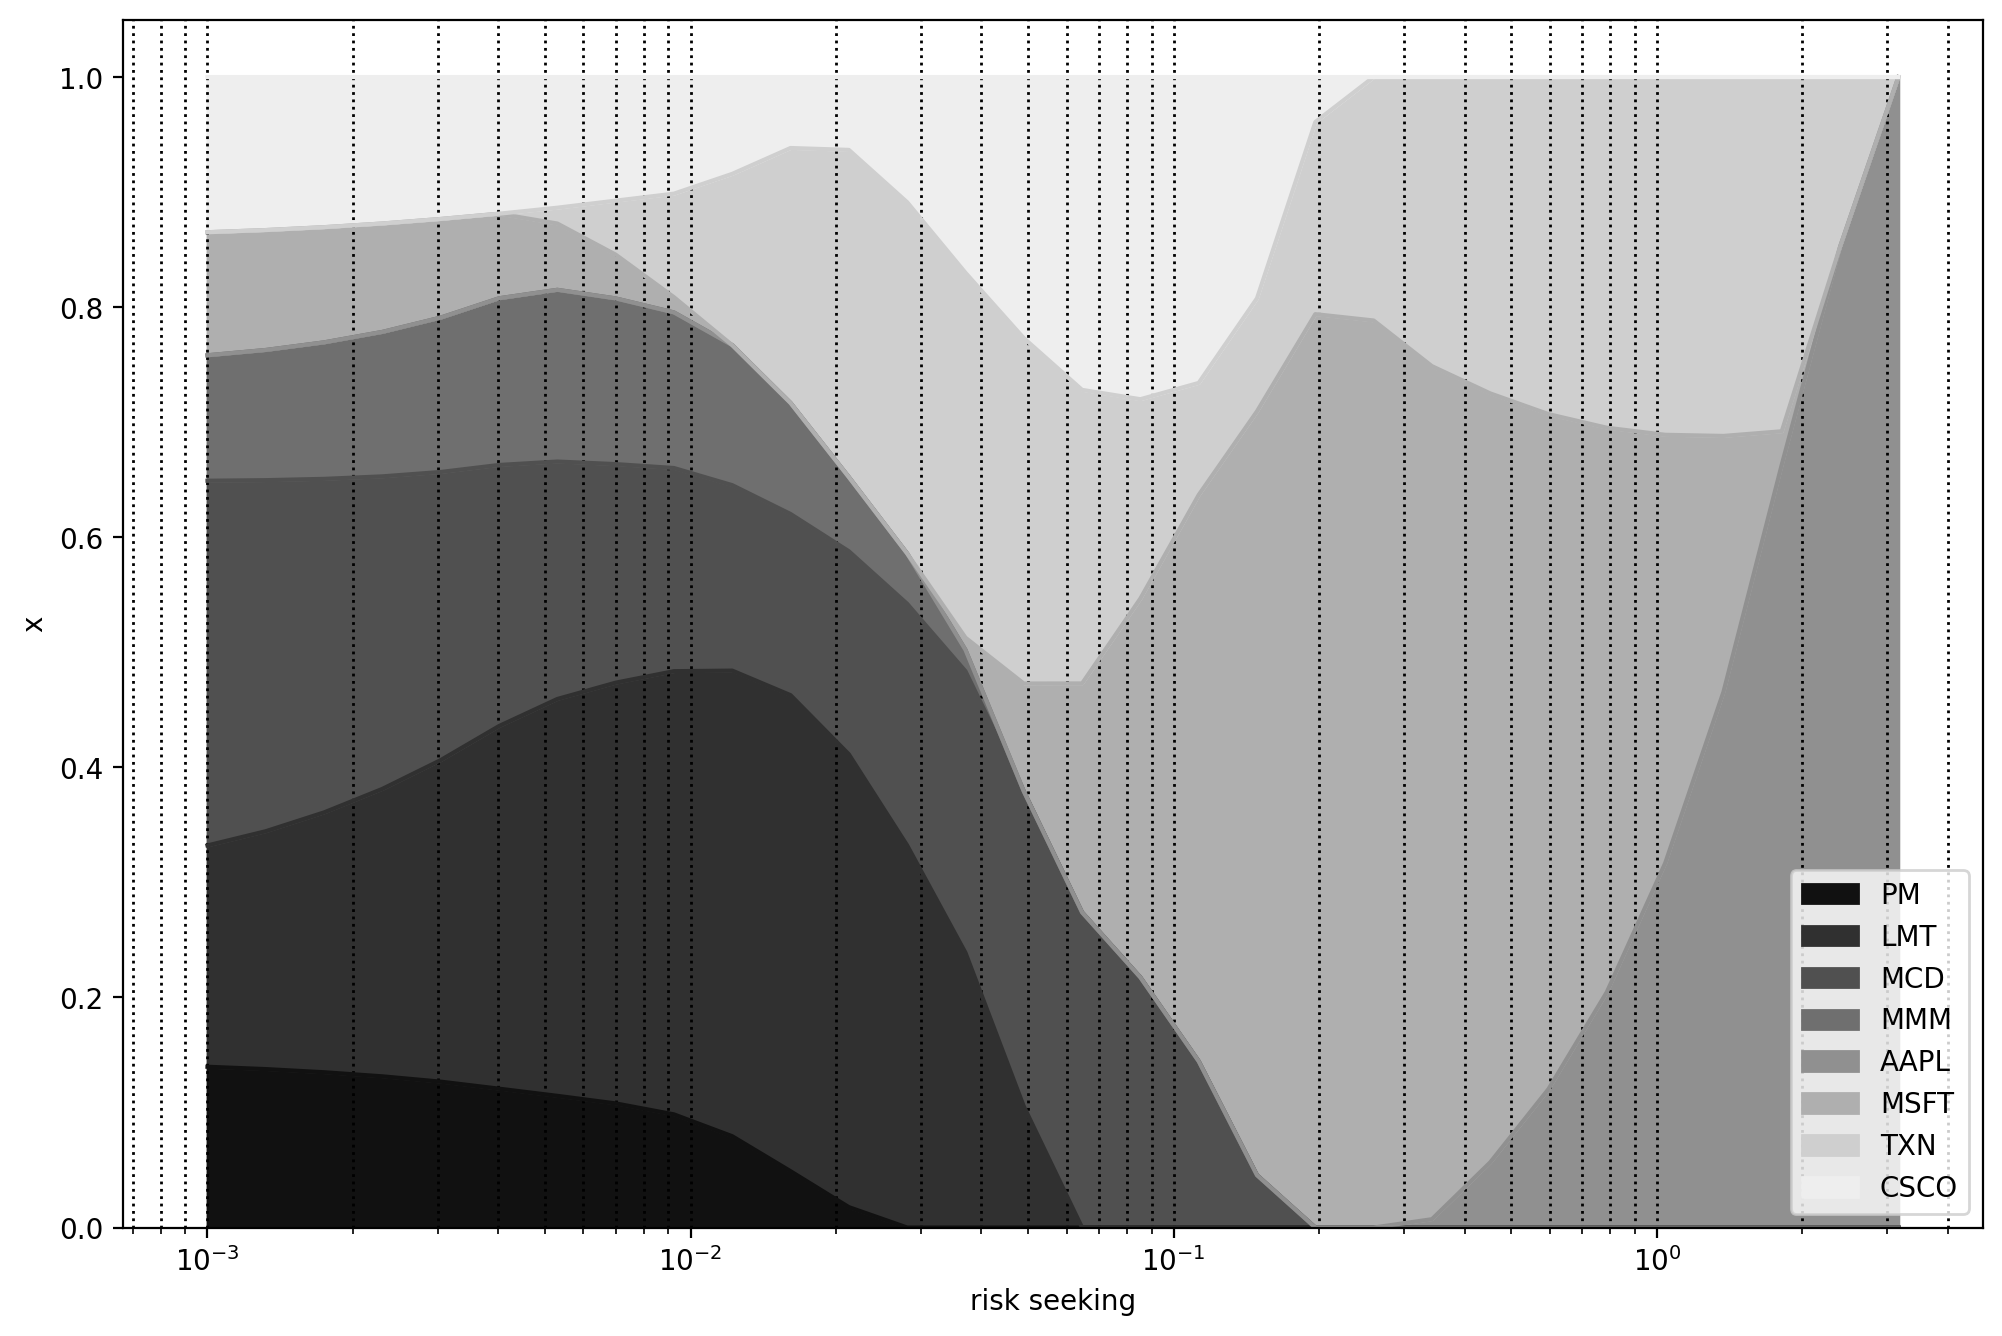

In [12]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax = df_result.set_index('inv_delta').iloc[:, 2:].plot.area(colormap=my_cmap, xlabel='risk seeking', ylabel="x", logx=True) 
ax.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)